In [1]:
# Load Dependencies
import tensorflow as tf
import keras
from keras import utils
from keras import np_
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.datasets import fashion_mnist
from keras.initializers import glorot_uniform
from keras.models import Model, load_model
import numpy as np

Using TensorFlow backend.


In [3]:
#Confirm keras is using GPU
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

#Manually set GPU config
config = tf.ConfigProto(device_count = {'GPU': 1, 'CPU': 8})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
# Get data
((X_train_raw, y_train_raw), (X_test_raw, y_test_raw)) = fashion_mnist.load_data()

# Reshape data
X_train_raw = np.array(X_train_raw).reshape(-1,28,28,1)
X_test_raw = np.array(X_test_raw).reshape(-1,28,28,1)

# Normalize X data
X_train = X_train_raw/255
X_test = X_test_raw/255

# Reshape y
y_train = utils.to_categorical(y_train_raw, num_classes=10)
y_test = utils.to_categorical(y_test_raw, num_classes=10)

# Shape of data
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

4423680/4422102 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [5]:
#Define the ResNet

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(28, 28, 1), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [7]:
# Create model
model = ResNet50(input_shape = (28, 28, 1), classes = 10)

# Compile model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 34, 34, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
# Fit model
H = model.fit(X_train, y_train,batch_size=128, epochs=50, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 176s 3ms/step - loss: 0.6179 - acc: 0.7944 - val_loss: 0.4238 - val_acc: 0.8475
Epoch 2/50
54000/54000 [==============================] - 105s 2ms/step - loss: 0.3476 - acc: 0.8741 - val_loss: 0.3705 - val_acc: 0.8623
Epoch 3/50
54000/54000 [==============================] - 105s 2ms/step - loss: 0.3023 - acc: 0.8894 - val_loss: 0.3482 - val_acc: 0.8763
Epoch 4/50
54000/54000 [==============================] - 105s 2ms/step - loss: 0.2668 - acc: 0.9027 - val_loss: 0.3332 - val_acc: 0.8797
Epoch 5/50
54000/54000 [==============================] - 105s 2ms/step - loss: 0.2463 - acc: 0.9089 - val_loss: 0.3170 - val_acc: 0.8832
Epoch 6/50
54000/54000 [==============================] - 105s 2ms/step - loss: 0.2325 - acc: 0.9140 - val_loss: 0.3248 - val_acc: 0.8883
Epoch 7/50
54000/54000 [==============================] - 104s 2ms/step - loss: 0.2181 - acc: 0.9196 - val_loss: 0.3355 - v

In [12]:
#Define y labels 

y_labels = ['t-shirts', 'trousers', 'pullovers', 
            'dresses', 'coats', 'sandals', 'shirts', 
            'sneakers', 'bags', 'ankle boots']

In [44]:
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")

# Get probabilities
predictions = model.predict(X_test, batch_size=128, verbose=1)

# Get class labels for predictions
pred_classes = predictions.argmax(axis=-1)

# Get class labels for y_test
y_test_classes = y_test.argmax(axis=-1)

# show formatted classification report
print(classification_report(y_test_classes, pred_classes,
    target_names=y_labels))

[INFO] evaluating network...
10000/10000 [==============================] - 4s 433us/step
              precision    recall  f1-score   support

    t-shirts       0.85      0.85      0.85      1000
    trousers       0.99      0.98      0.99      1000
   pullovers       0.79      0.90      0.84      1000
     dresses       0.92      0.89      0.91      1000
       coats       0.90      0.78      0.83      1000
     sandals       0.98      0.98      0.98      1000
      shirts       0.73      0.74      0.74      1000
    sneakers       0.93      0.98      0.96      1000
        bags       0.97      0.98      0.98      1000
 ankle boots       0.99      0.94      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



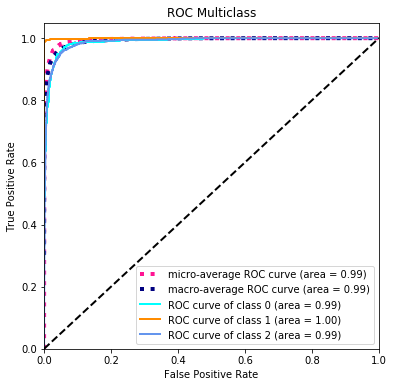

In [76]:
# Plot ROC and AUC
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = 10

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6,6))
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Multiclass')
plt.legend(loc="lower right")
plt.show()